# Census - Income Prediction

In [11]:
# importing libraries

import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from pandas.api.types import CategoricalDtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [13]:
# Load the datasets
columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv('/content/sample_data/adult.data', names = columns, sep=' *, *', na_values='?')
test_data = pd.read_csv('/content/sample_data/adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?')

In [14]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [15]:
test_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


# EDA and FE

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


~ There are in total 32561 samples in the train data set.
 
~ There are both categorical and numerical attributes in the dataset. 

~ The columns workClass, occupation, native-country have missing values.

In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


~ There are in total 16281 samples in the test data set. 

~ There are both categorical and numerical attributes in the dataset.

~ There are no missing values.

In [18]:
# Handling numerical attributes
num_attributes = train_data.select_dtypes(include=['int'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


~ The variables age, hours-per-week are self-explanatory.

~ fnlwgt: sampling weight

~ education-num: number of years of education in total

~ capital-gain/capital-loss: income from investment sources other than salary/wages

~ fnlwgt is not related to the target variable income and will be removed before building the model.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

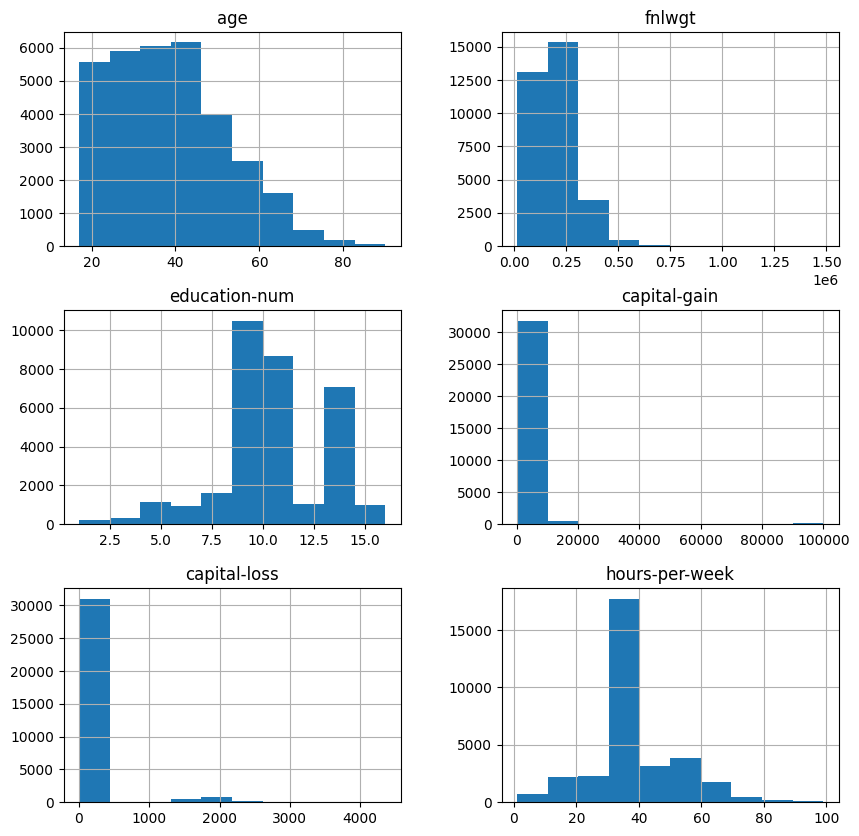

In [19]:
num_attributes.hist(figsize=(10,10))

In [20]:
num_attributes.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


~ None of the numerical attributes have missing values. 

~ The values are on different scales. Many machine learning models require the features to be on the same scale.

~ We can see that there are many outliers present in the data, we will use StandardScaler from sklearn library.

In [21]:
# Handling categorical attributes
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


<Axes: xlabel='count', ylabel='workClass'>

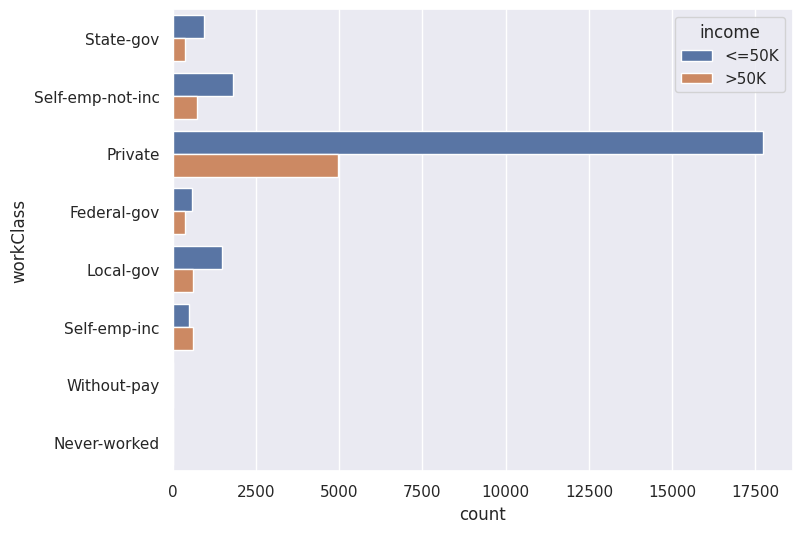

In [22]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(y='workClass', hue='income', data = cat_attributes)

<Axes: xlabel='count', ylabel='occupation'>

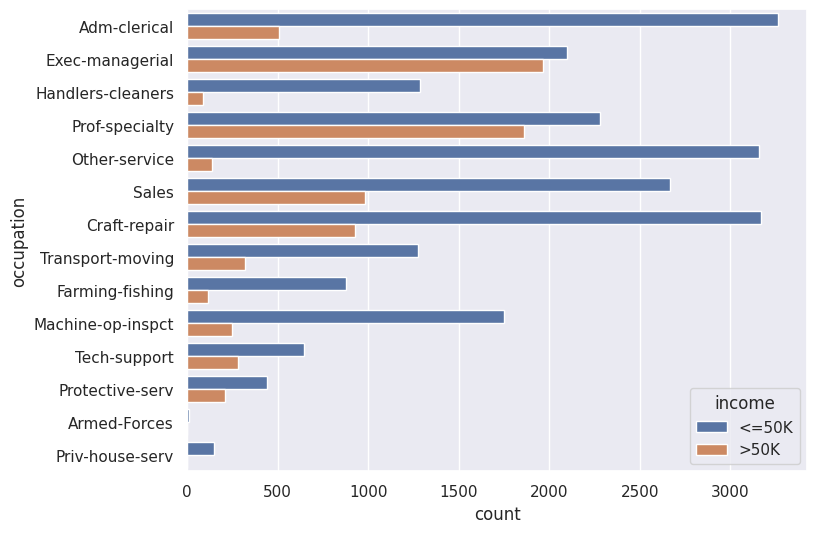

In [23]:
sns.countplot(y='occupation', hue='income', data=cat_attributes)

~ All the variables are self-explanatory.

~ The column education is just a string representation of the column education-num. We will drop the education column. 

~ The variables workClass, occupation, native-country have missing values. We will replace the missing values in each column with the most_frequent occurring value of that column.

~ We need to handle the numerical and categorical attributes differently. Numerical attributes needs to be scaled, where as we need to fill the missing values and then encode the categorical values into numerical values. To apply these sequence of transformations we will use the sklearn Pipeline. We will also build custom transformers that can be directly used with Pipeline.

# Creating Pipelines

In [24]:
# Column selector custom pipeline
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

In [25]:
# Numerical data pipeline
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
])

In [29]:
# Categorical data pipeline and handling missing values
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

In [28]:
# Encoding categorical data to numerical
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

In [30]:
# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

In [31]:
# Full pipeline
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

# Preprocessing

In [34]:
# drop fnlwgt
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [35]:
# copy the data before preprocessing
train_copy = train_data.copy()

# convert the income column to 0 or 1 and then drop the column for the feature vectors
train_copy["income"] = train_copy["income"].apply(lambda x:0 if x=='<=50K' else 1)

# creating the feature vector 
X_train = train_copy.drop('income', axis =1)

# target values
Y_train = train_copy['income']

print(X_train.columns)

Index(['age', 'workClass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')


# Logistic Regression and hyperparameter tuning

In [37]:
# pass the data through the full_pipeline
X_train_processed = full_pipeline.fit_transform(X_train)
print(X_train_processed.shape)

(32561, 81)


In [38]:
model = LogisticRegression(random_state=0)
model.fit(X_train_processed, Y_train)

LogisticRegression(random_state=0)

In [40]:
model.coef_

array([[ 0.3125196 ,  0.77225077,  2.30522538,  0.26019853,  0.3926509 ,
        -0.40468067, -0.05739912, -0.17406221,  0.2220115 ,  0.56694854,
        -0.92315756, -0.18350919, -2.11482651, -1.62740492, -1.71062504,
        -1.51733222, -1.63289586,  0.34300981, -0.17487648,  0.49115953,
        -0.2672077 ,  0.00838173, -1.07798434, -0.5047633 , -0.34665381,
        -0.90006293, -1.29778774,  0.35524069,  0.23563048, -1.84537155,
        -0.40129658,  0.00959643, -1.17808344, -0.13302997,  1.2795792 ,
        -0.70803927, -0.17577824, -0.06435095, -0.58806737, -0.45648833,
        -0.83422255, -0.57132585,  0.39766475,  0.26901857, -0.41376935,
         0.11243909, -0.5968353 , -0.3035869 ,  0.2450622 ,  0.13429507,
        -0.5871598 , -0.96836105, -0.09187958,  0.61629824, -1.23162464,
         0.23349642, -0.21704322, -0.10777473, -0.98025213, -1.49238751,
        -0.15296314, -0.16954326,  0.02868502, -0.09177452, -0.88778747,
        -0.63932744, -0.54054047, -0.2662795 ,  0.3

In [41]:
# Testing the model
# take a copy of the test data set
test_copy = test_data.copy()

# convert the income column to 0 or 1
test_copy["income"] = test_copy["income"].apply(lambda x:0 if x=='<=50K.' else 1)

# separating the feature vecotrs and the target values
X_test = test_copy.drop('income', axis =1)
Y_test = test_copy['income']

X_test.columns

Index(['age', 'workClass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')

In [42]:
X_test_processed = full_pipeline.fit_transform(X_test)
X_test_processed.shape

(16281, 81)

In [43]:
predicted_classes = model.predict(X_test_processed)
print(predicted_classes)

[0 0 0 ... 1 0 1]


In [44]:
# Model evaluation
accuracy_score(predicted_classes, Y_test.values)

0.8524660647380382

[[11585  1552]
 [  850  2294]]


Text(66.25, 0.5, 'Actual classes')

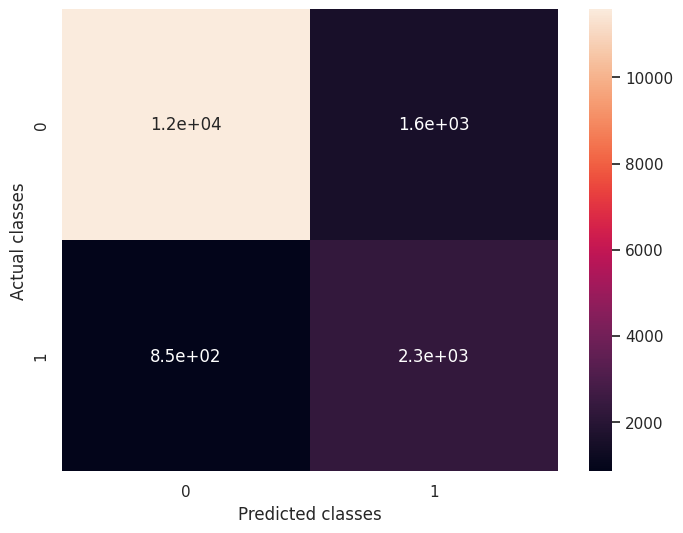

In [46]:
# Confusion matrix
sns.set(rc={'figure.figsize':(8,6)})
cfm = confusion_matrix(predicted_classes, Y_test.values)
sns.heatmap(cfm, annot=True)
print(cfm)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [47]:
# Cross validation
cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_train_processed, Y_train, cv=5)
print(scores)
print(np.mean(scores))

[0.84722862 0.84935504 0.8519656  0.85365479 0.85227273]
0.8508953553863734


In [48]:
# hyperparameter tuning
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
random_state=[0]

# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

In [50]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, cv=5)
best_model = clf.fit(X_train_processed, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [51]:
best_predicted_values = best_model.predict(X_test_processed)
print(best_predicted_values)

[0 0 0 ... 1 0 1]


In [52]:
accuracy_score(best_predicted_values, Y_test.values)

0.8524660647380382

~ Conclusion :- Here we are getting around about 85.24% accuracy with Logistic regression while training the model. With hyperparameter tuning with different parameters using GridSearchCV we get around about 85.24% as best accuracy with parameters:{C = 1, penalty = l2}.